In [1]:
# Package Import
from astropy.io import fits
import numpy as np
from matplotlib import pyplot as plt
from astropy.wcs import WCS
from photutils import DAOStarFinder
from astropy.stats import mad_std
from photutils import aperture_photometry, CircularAperture, CircularAnnulus
from glob import glob
import datetime
from datetime import timedelta
%matplotlib inline

## Masterbias 

In [2]:
m91_bias = glob('data_2019/M91/bias/*')

def masterBias(files): # function for computing masterbias image
    mbias = np.zeros([2048,2048])
    for i in range(len(files)):
        image = fits.open(files[i])[0].data
        fixedImage = np.delete(image,slice(50),axis=1)
        mbias += fixedImage
    bigImage = mbias/len(files)
    return bigImage

m91_masterBias = masterBias(m91_bias)

In [3]:
nnSer_bias = glob('data_2019/NNSer/bias/*')

nnSer_masterBias = masterBias(nnSer_bias)

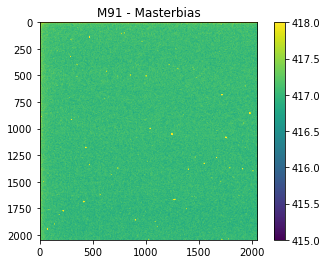

In [4]:
plt.imshow(m91_masterBias,vmin=415, vmax= 418)
plt.colorbar()
plt.title('M91 - Masterbias');


In [5]:
a=fits.open(m91_bias[0])[0].data
b=np.delete(a,slice(49),axis=1)
np.shape(b)
#plt.imshow(b,vmin=415, vmax= 418)

(2048, 2049)

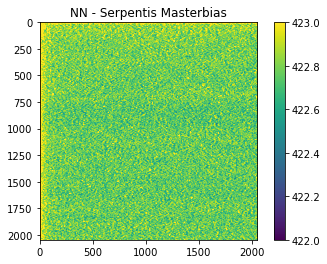

In [6]:
plt.imshow(nnSer_masterBias,vmin=422, vmax= 423)
plt.colorbar()
plt.title('NN - Serpentis Masterbias');
#plt.savefig('nnSer_masterbias.eps')

## Masterflats - M91

In [7]:
def masterFlat(files, masterbias): # function for determining masterbias
    mflatDict = {} # creating a dictionary to store all of the images
    for f in files: # looping over each filter
        subfiles = glob(f+'/*')
        for i in range(len(subfiles)):
            mflat = np.zeros([2048,2048])
            rawImage = fits.open(subfiles[i])[0].data # opening image
            image = np.delete(rawImage,slice(50),axis=1) # getting rid of the first fifty columns
            bflat = image - masterbias # subtracting masterbias
            mflat += bflat
        masterFlat = mflat/len(files) #master flat
        center = masterFlat[974:1074,974:1074]
        normMasterFlat = masterFlat/(np.max(center)) # normalised masterflat
        mflatDict[f[20]] = [masterFlat,normMasterFlat] #adding to dictionary
    
    return mflatDict


In [8]:
flatFiles = glob('data_2019/M91/flats/*')
m91_masterFlats = masterFlat(flatFiles,m91_masterBias)

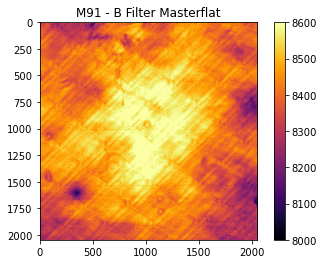

In [9]:
plt.imshow(m91_masterFlats['B'][0],cmap ='inferno',vmin=8000,vmax=8600)
plt.colorbar()
plt.title('M91 - B Filter Masterflat');
#plt.savefig('m91_masterflatB.eps')

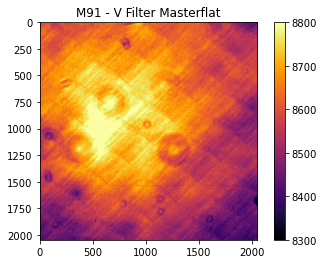

In [10]:
plt.imshow(m91_masterFlats['V'][0],cmap='inferno',vmin=8300,vmax=8800)
plt.colorbar()
plt.title('M91 - V Filter Masterflat');
#plt.savefig('m91_masterflatV.eps')

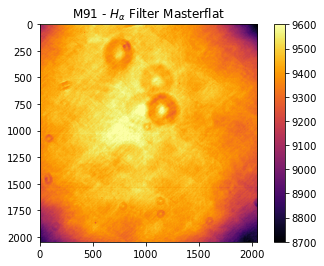

In [11]:
plt.imshow(m91_masterFlats['H'][0],cmap='inferno',vmin=8700,vmax=9600)
plt.colorbar()
plt.title(r'M91 - $H_\alpha$ Filter Masterflat');
#plt.savefig('m91_masterflatH.eps')

## Masterflats - NN Serpentis

In [12]:
nnSer_flats = glob('data_2019/NNSer/flats/*')
nnSer_masterFlats = masterFlat(nnSer_flats,nnSer_masterBias)

In [13]:
nnSer_masterFlats['Clear'] = nnSer_masterFlats['s']
del nnSer_masterFlats['s']

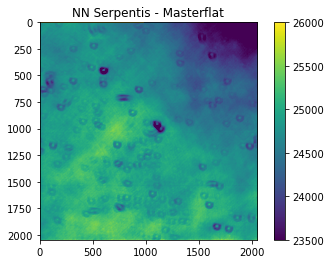

In [14]:
plt.imshow(nnSer_masterFlats['Clear'][0],vmin=23500, vmax=26000)
plt.colorbar()
plt.title('NN Serpentis - Masterflat');
#plt.savefig('nnSer_masterflat.eps')

## Image Filtering - M91

In [15]:
## Producing Image of M91 under B filter

rawB_M91 = glob('data_2019/M91/object/B/*')
rawH_M91 = glob('data_2019/M91/object/Halpha_NII/*')
rawV_M91 = glob('data_2019/M91/object/V/*')

def imageFiltering(files,mbias,mflat): #flat has to be normalised
    avgImage = np.zeros([2048,2048])
    for file in files:
        image = fits.open(file)[0].data
        correctedImage = np.delete(image,slice(50),axis=1)
        avgImage += (correctedImage-mbias)
    almostImage = avgImage/len(files)
    finalImage = almostImage/mflat
    return finalImage


m91_B = imageFiltering(rawB_M91,m91_masterBias,m91_masterFlats['B'][1])
#finalB = fits.PrimaryHDU(m91_B)
#finalB.writeto('M91_B.fits')

m91_H = imageFiltering(rawH_M91,m91_masterBias,m91_masterFlats['H'][1])
#finalH = fits.PrimaryHDU(m91_H)
#finalH.writeto('M91_H.fits')

m91_V = imageFiltering(rawV_M91,m91_masterBias,m91_masterFlats['V'][1])  
#finalV = fits.PrimaryHDU(m91_V)
#finalV.writeto('M91_V.fits')

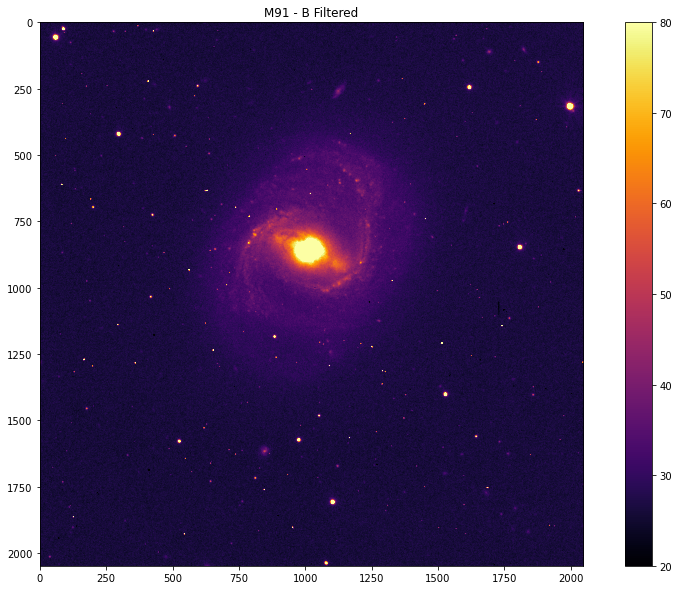

In [16]:
plt.rcParams['figure.figsize'] = (15,10)
plt.imshow(m91_B,cmap ='inferno',vmin=20,vmax=80)
plt.colorbar()
plt.title('M91 - B Filtered');
np.max(m91_B)
plt.savefig('M91_B.png')

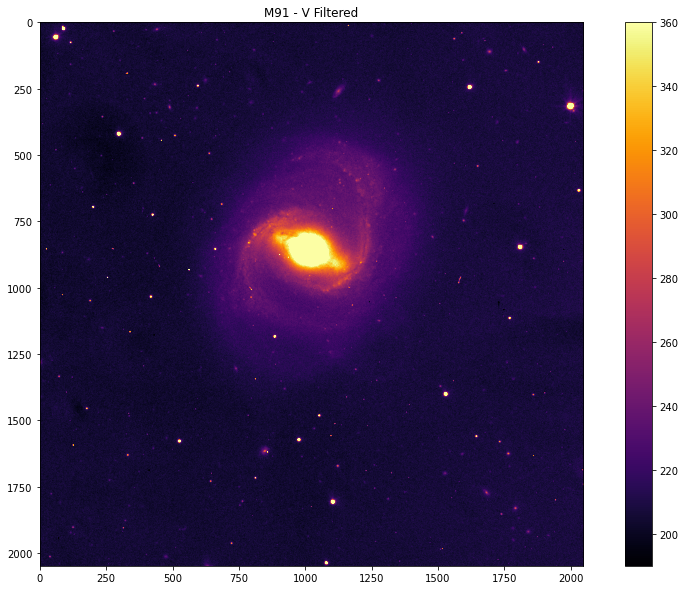

In [17]:
plt.imshow(m91_V,cmap ='inferno',vmin=190,vmax=360)
plt.colorbar()
plt.title('M91 - V Filtered');
plt.savefig('M91_V.png')

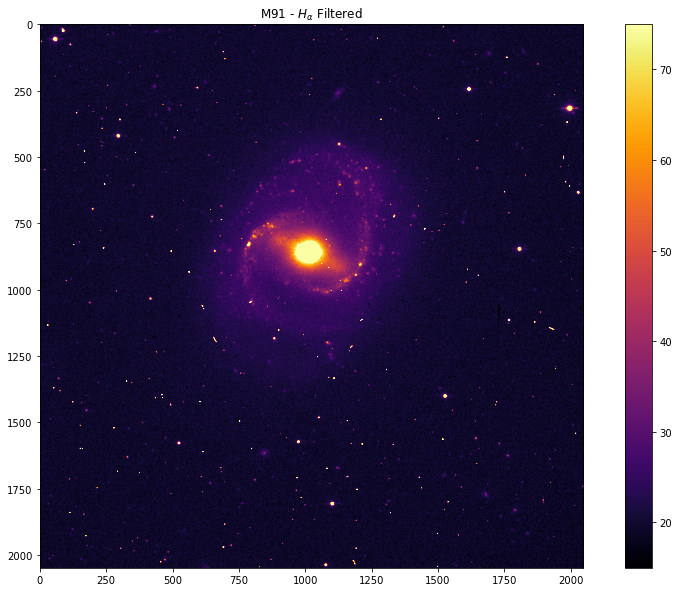

In [18]:

plt.imshow(m91_H,cmap ='inferno',vmin=15,vmax=75)
plt.colorbar()
plt.title(r'M91 - $H_\alpha$ Filtered');
plt.savefig('M91_H.png')

## Image Filtering - NN Serpentis

In [19]:
raw_nnSer = glob('data_2019/NNSer/object/clear/*') # correcting each raw image of NN Ser and saving it
filtered_nnSer = imageFiltering(raw_nnSer,nnSer_masterBias,nnSer_masterFlats['Clear'][1])
count = 0
universalTimes = []
normalised=[]
for i in raw_nnSer:
    blank = np.zeros([2048,2048])
    image = fits.open(i)[0].data
    correctedImage = np.delete(image,slice(50),axis=1)
    blank += correctedImage
    blank -= nnSer_masterBias
    blank /= nnSer_masterFlats['Clear'][1]
    final = fits.PrimaryHDU(blank)
    #final.writeto('corrected_nnSer_'+str(count)+'.fits')
    count+=1


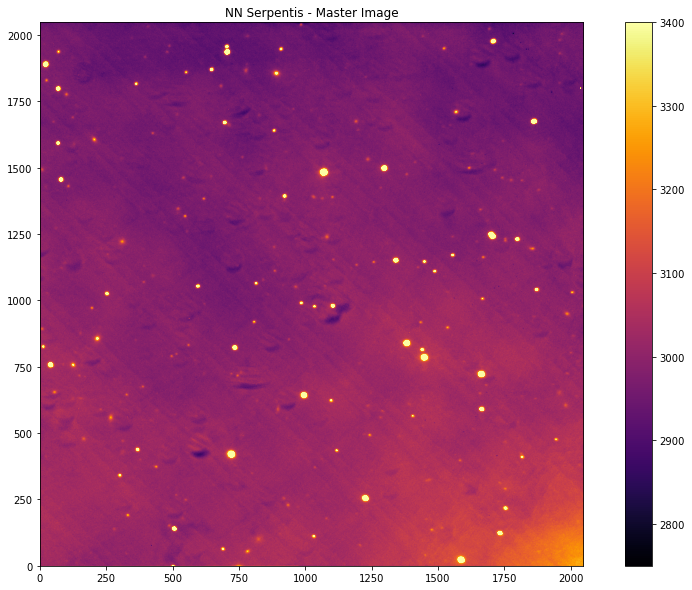

In [21]:
plt.imshow(filtered_nnSer,cmap='inferno',vmin=2750,vmax=3400)
plt.gca().invert_yaxis()
#plt.gca().invert_xaxis()
plt.colorbar()
plt.title('NN Serpentis - Master Image');
plt.savefig('NNSer_master.eps')

In [2]:
# Save final filtered image to a seperate file

final = fits.PrimaryHDU(filtered_nnSer)
#final.writeto('Final_NNSer.fits')

NameError: name 'fits' is not defined